In [1]:
import pypld.pyPLD as pyPLD

import numpy as np
from scipy import ndimage, misc
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib


In [2]:
#global parameters
dim_model=10
dim_experimental=4.8
res_experimental=480

res_model=int(res_experimental*dim_model/dim_experimental)

ang_step=29/5

#set plume modeling by double plumes to True
double=True 

xx, yy = np.mgrid[-dim_model/2:dim_model/2:dim_model/res_model, -dim_model/2:dim_model/2:dim_model/res_model] # def mgrid for use in navigating sample later


### Sample holder

In [3]:
##define our sample holder 
a=0.75 #cm
b=1 #cm

A = np.argwhere(xx==-a-b)[0,0]
B = np.argwhere(xx== -a)[0,0]
C = np.argwhere(xx== +a)[0,0]
D = np.argwhere(xx== +a+b)[0,0]
E = np.argwhere(xx== -b/2)[0,0]
F = np.argwhere(xx== +b/2)[0,0]


sample_holder=np.array([[E,F,E,F],[A,B,E,F],[C,D,E,F],[E,F,A,B],[E,F,C,D]])

### Plume curve fit

### Import and interpolate film data


30.888687
517.275269


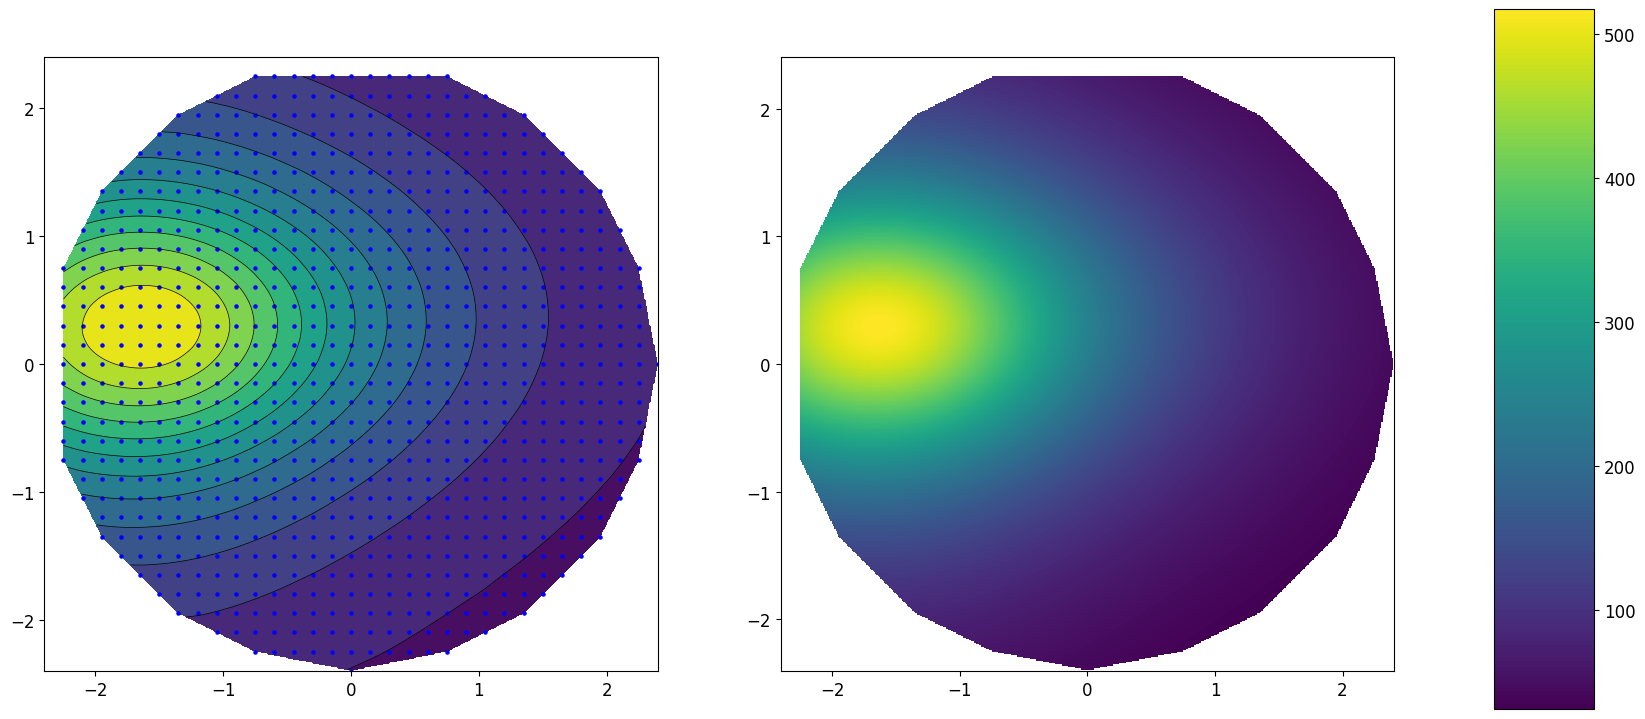

In [5]:
filename ='TiO2_100sccmO2_onSI_15000pulses_MAP1.txt'

Xi_TiO2, Yi_TiO2, Zi_TiO2 = pyPLD.read_elipsometry_data(filename,res=res_experimental, size_x=[-dim_experimental/2,dim_experimental/2], size_y=[-dim_experimental/2,dim_experimental/2],save=False)

Image rotation needed: 1.5750077854939235
Plume shift / centre: [0.2855949895615866, -1.6484342379958246]
Plume shift / centre after rot: [0.32567849686847605, -1.638413361169102]


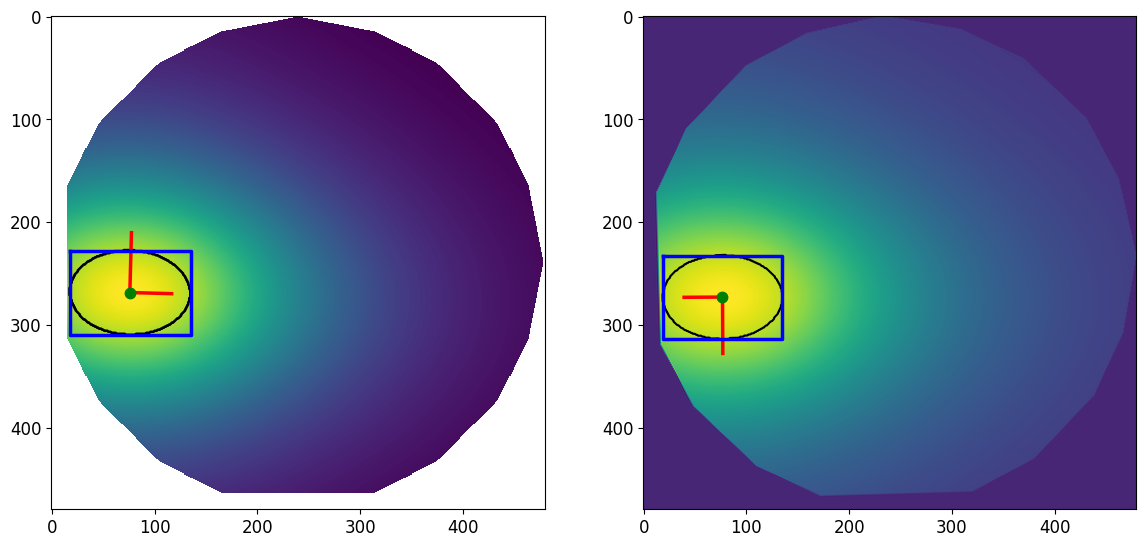

In [6]:
Shift_after_rot_TiO2,Shift_plume_TiO2, rotation_angle_TiO2=pyPLD.find_rotation_angle_and_centre_of_plume(Xi_TiO2, Yi_TiO2, Zi_TiO2, treshold=460, print_image=True)

### Fit film dilm data

5.377998071382613 9.999999999999998
30.000000000000004 44.956024599639235


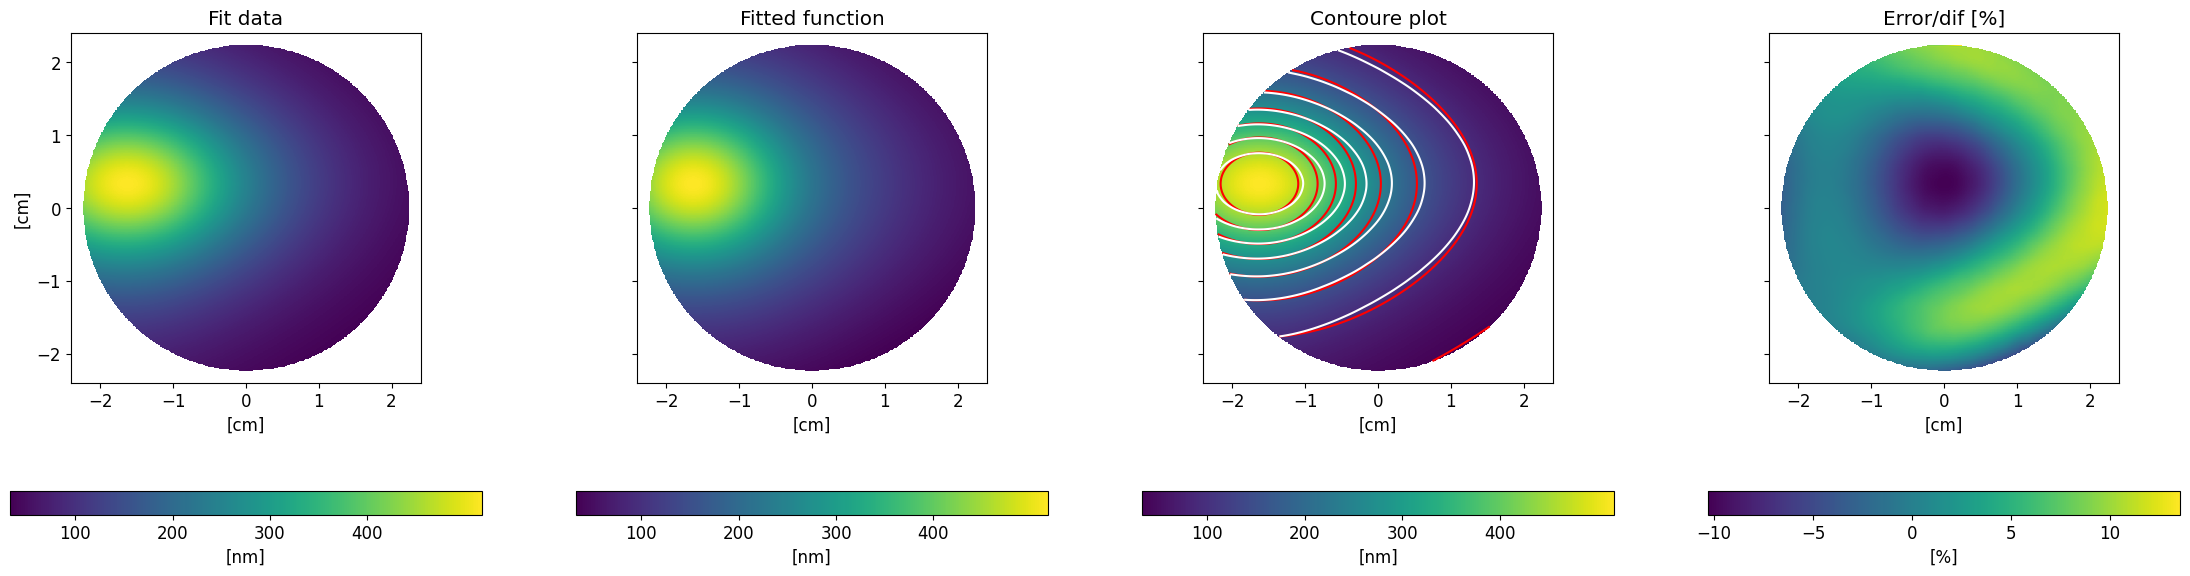

In [7]:
initial_guess = (
    np.max(Zi_TiO2), #plume max thikness
    4.405, #target to substrate distance meassured
    13.4, #initial geuss n_1
    6,#initial geuss m_1
    86, #initial geuss n_2
    13, #initial geuss m_2
    Shift_after_rot_TiO2[1], #plume shift found above
    Shift_after_rot_TiO2[0]) #plume shift found above

bounds=(
    (np.max(Zi_TiO2)-0.1,
     4.4,
     5,
     3,
     30,
     12,
     Shift_after_rot_TiO2[1]-0.01,
     Shift_after_rot_TiO2[0]-0.01),
    
    (np.max(Zi_TiO2)+0.1,
     4.41,
     30,
     10,
     100,
     100,
     Shift_after_rot_TiO2[1]+0.01,
     Shift_after_rot_TiO2[0]+0.01))

#Fitting
fit_data, data_fitted, popt_TiO2 = pyPLD.curve_fit_plume(Xi_TiO2,Yi_TiO2,Zi_TiO2, res_experimental, rotation_angle_TiO2, 15000, initial_guess, bounds, double=double )


pyPLD.plot_compare(Xi_TiO2, Yi_TiO2, fit_data,data_fitted,res_experimental, data_lable='Fit data', model_lable='Fitted function', error_lable='Error/dif [%]',save=False, filename='TiO2',fig_for_print=False, N_contours=8,D_ticks_cbar=100,D_tick_error_cbar=5)

print(popt_TiO2[2],popt_TiO2[3])
print(popt_TiO2[4],popt_TiO2[5])


### Brute force optimize thickness

In [8]:
save=False 
filename= '_18000_pulses_0-4cm_shift_optimized_plume'

In [9]:
shift_steps = 0.5 #size of shift steps in cm
#shift_steps = 0.2 #uncomment for high step resolution but long run time

# define grid in cm
shift_X = np.arange(0,3.1,shift_steps)
shift_Y = np.arange(0,3.1,shift_steps)


n_pulses=18000

thinfilms=np.empty([shift_X.shape[0],shift_Y.shape[0],res_model,res_model])

n=0
for i in shift_X:
    m=0
    for j in shift_Y:
        plume =pyPLD.def_plume(T_0=popt_TiO2[0],
                z=popt_TiO2[1], 
                n=[popt_TiO2[2],popt_TiO2[4]], 
                m=[popt_TiO2[3],popt_TiO2[5]], 
                shift=[i,j],
                dim=dim_model,
                res=res_model,
                double=double
                )  
        thinfilms[n,m][:,:] =pyPLD.simulate_pld_faster(plume,n_pulses,ang_step, print_output=False)
        m=m+1
    n=n+1
print(thinfilms.shape)

(7, 7, 1000, 1000)


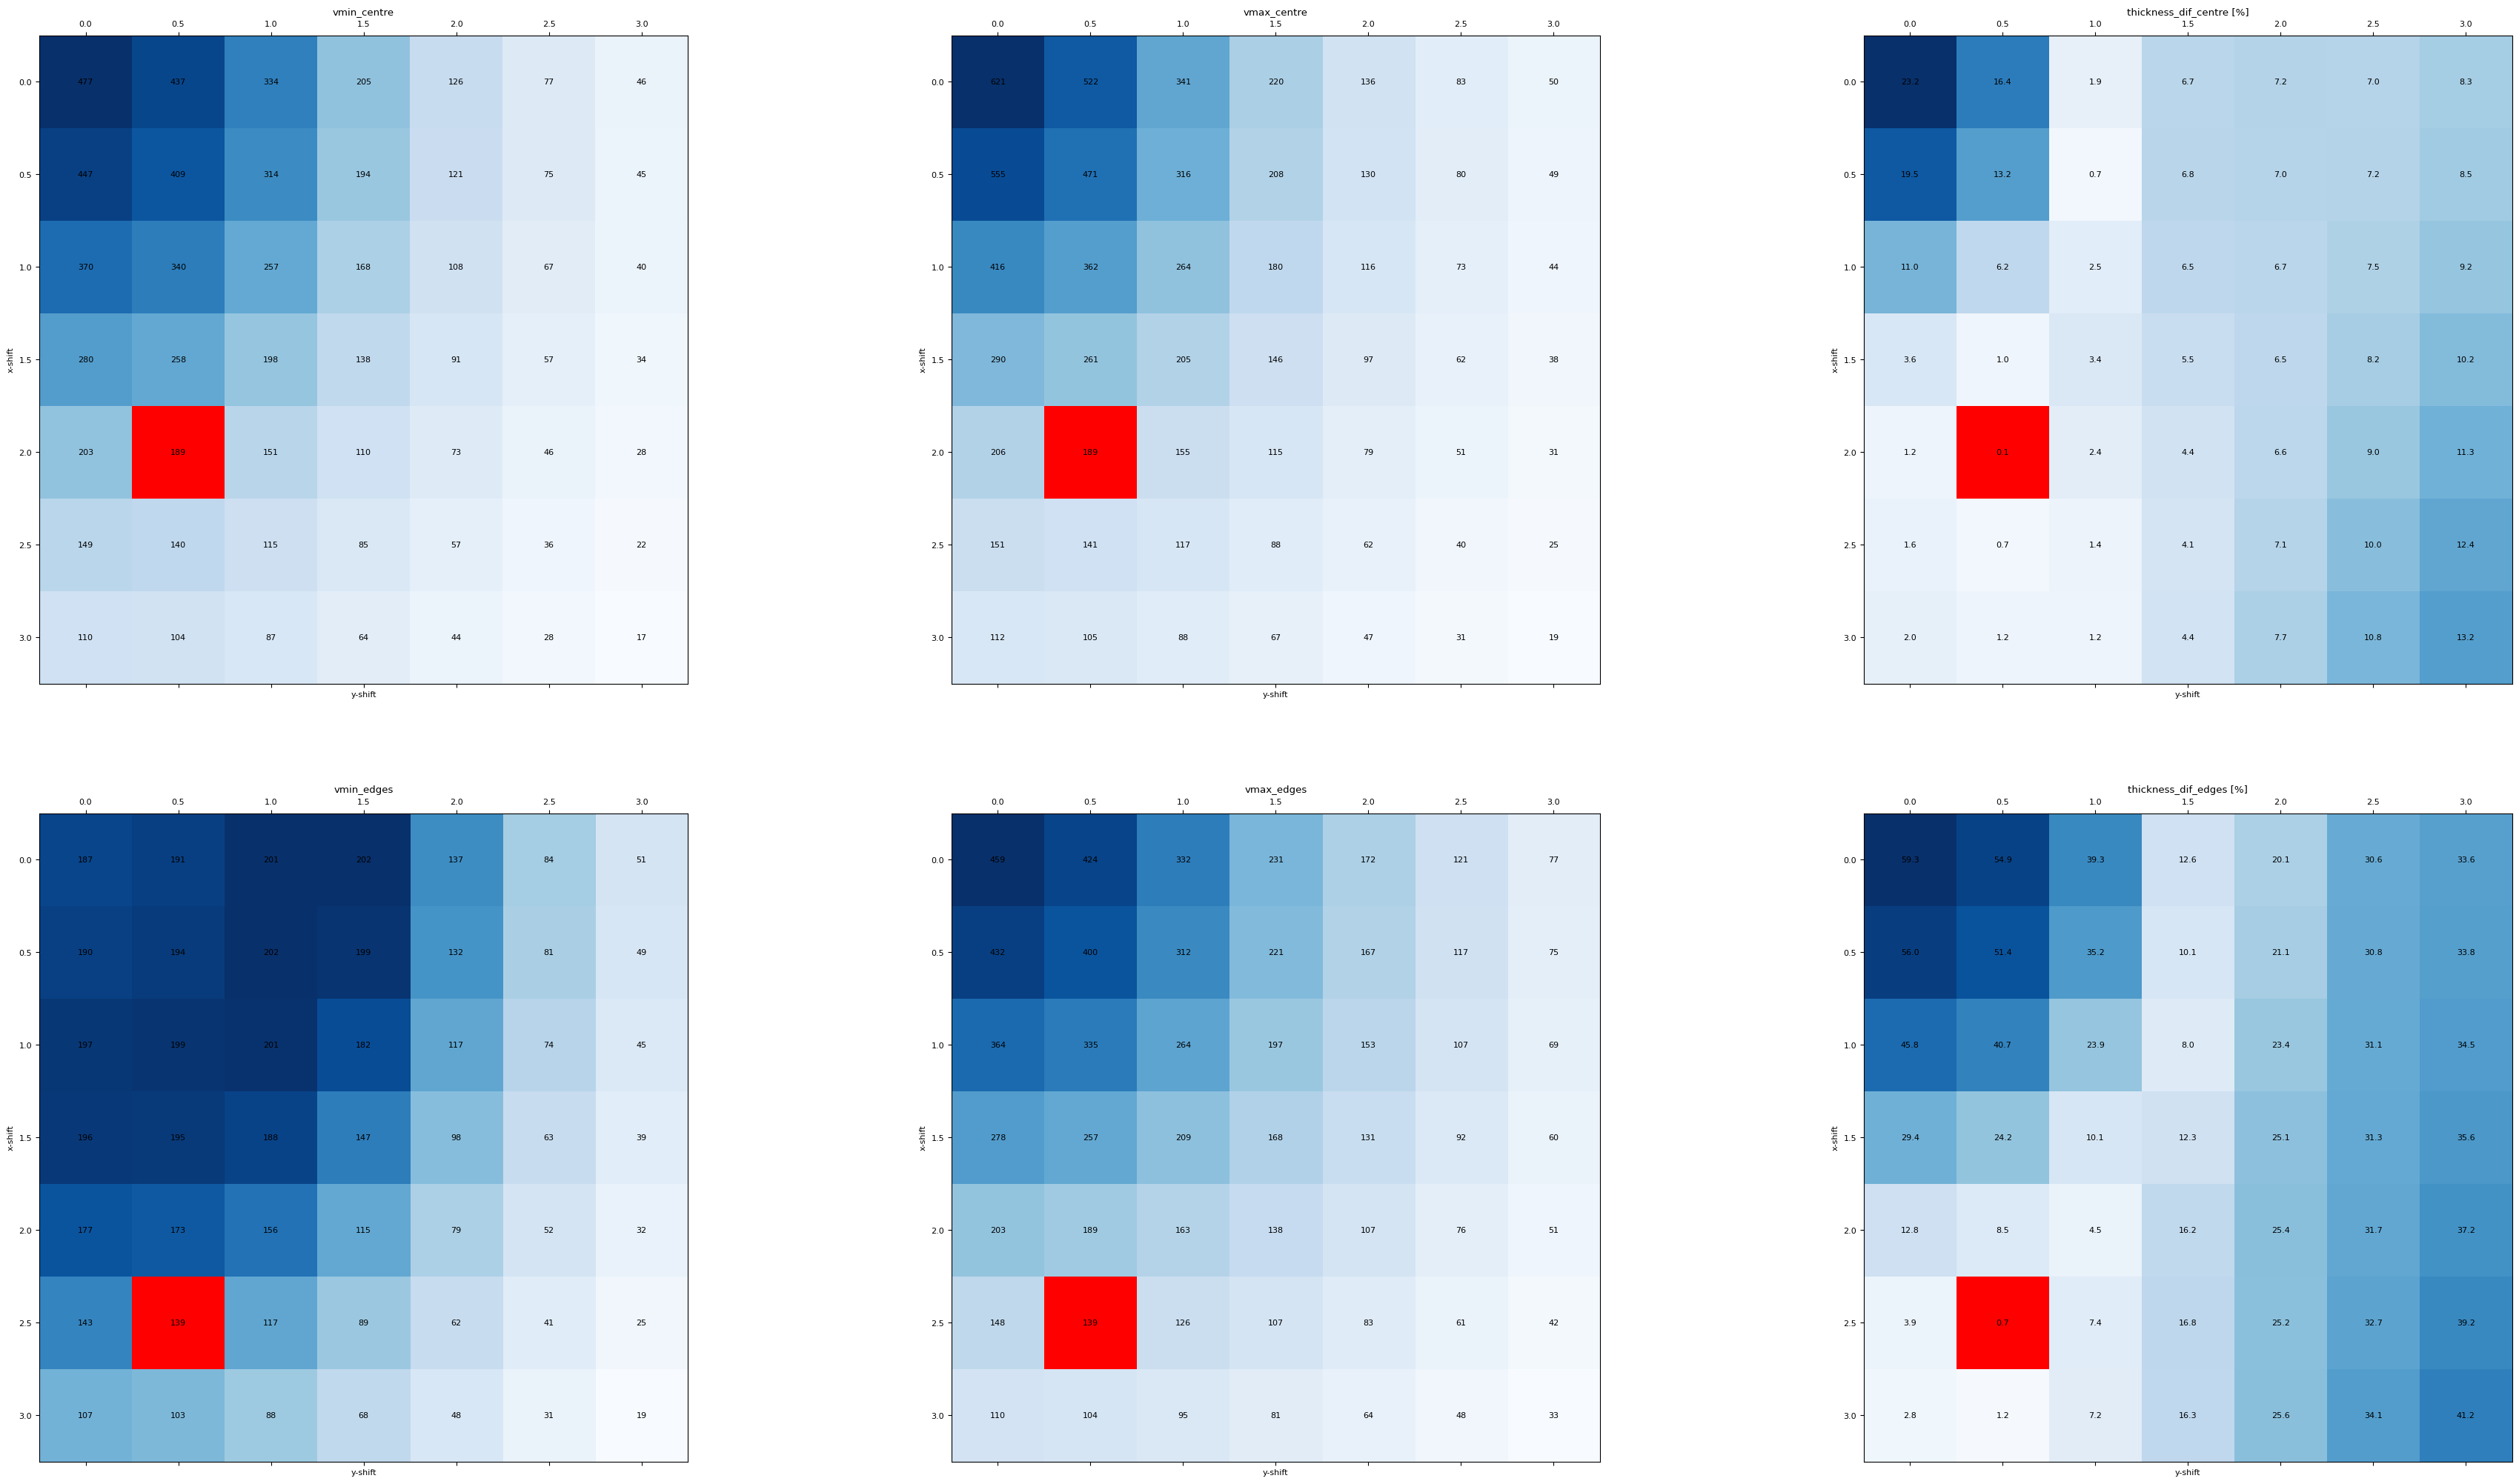

In [10]:
pyPLD.Plot_array_of_thikness_dif(xx,yy,thinfilms,shift_X, shift_Y,sample_centre=sample_holder[0], sample_edge=sample_holder[1],filename=filename,save=save)

### Simulate optimized film
18000p

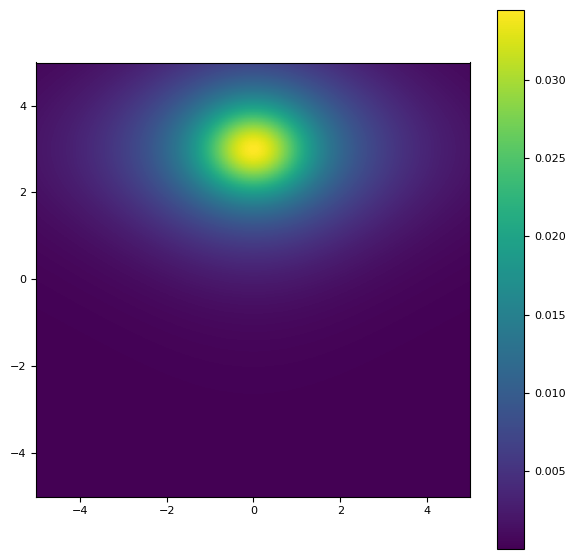

The number of pulses per substrate rotation are:  62.06896551724138
Shift in degrees between substrate rotations is  -0.4
Number of full substrate rotations needed to be be a whole number of pulses:  29
Extra pulses neeeded:  2
29.0 whole rounds are completed in 1800 pulses.
Pulses in adittion to evenly distributed pulse number:  0
Suggested total number of pulses:  18000


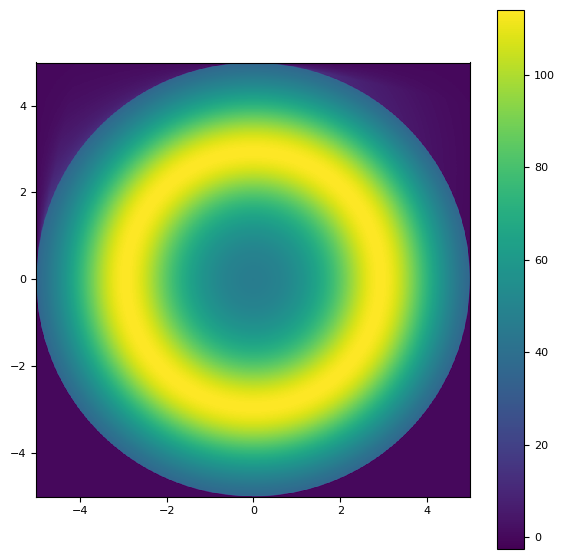

In [11]:
n_pulses=18000


plume =pyPLD.def_plume(T_0=popt_TiO2[0],
                 z=popt_TiO2[1], 
                 n=[popt_TiO2[2],popt_TiO2[4]], 
                 m=[popt_TiO2[3],popt_TiO2[5]], 
                 shift=[0,3],
                 dim=dim_model,
                 res=res_model,
                 double=double
                )  

pyPLD.plot_cb(xx,yy,plume)

thinfilm_4 =pyPLD.simulate_pld_faster(plume,n_pulses,ang_step)

pyPLD.plot_cb(xx,yy,thinfilm_4)

123.674484
148.452209


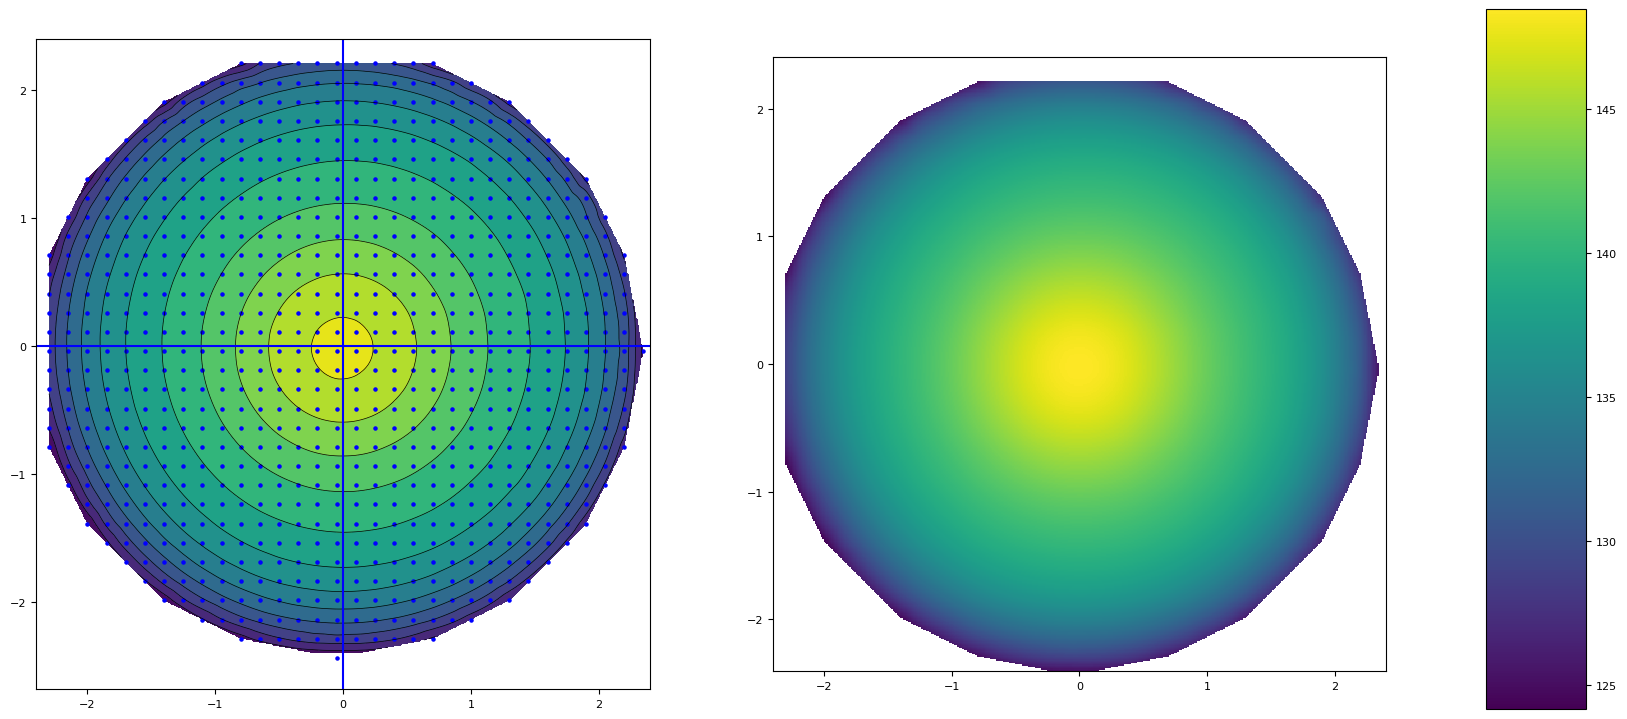

In [12]:
filename ='210222_TiO2_18k_rotating_optimalposition.txt'

Xi_5, Yi_5, Zi_5 = pyPLD.read_elipsometry_data(filename,res=res_experimental, size_x=[-2.4,2.4], size_y=[-2.4,2.4],centre=[-0.05,-0.04],centre_line=True, save=False)

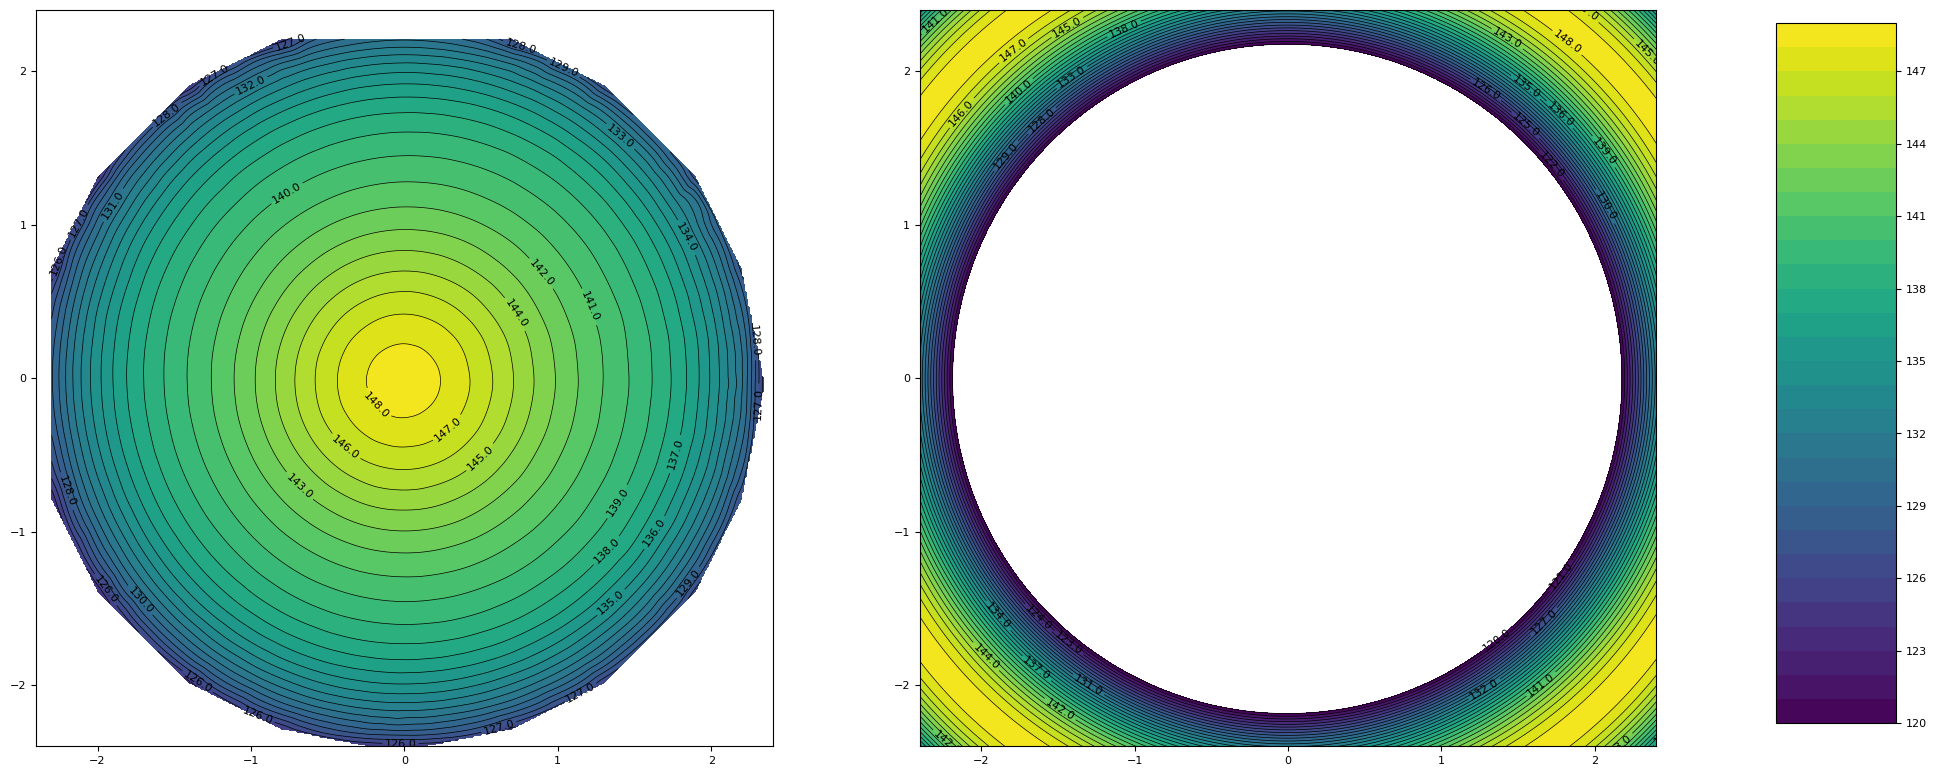

In [13]:
pyPLD.plot_countour_compare(xx,yy,thinfilm_4,Xi_5,Yi_5,Zi_5,dim_experimental,contours=np.arange(120,150,1))

/home/hognely/Documents/PHD/PLD simulering/pyPLD/src/pypld/pyPLD.py:411: UserWarning: No contour levels were found within the data range.
  ax[2].contour(Xi,Yi,model, contours, colors='r')


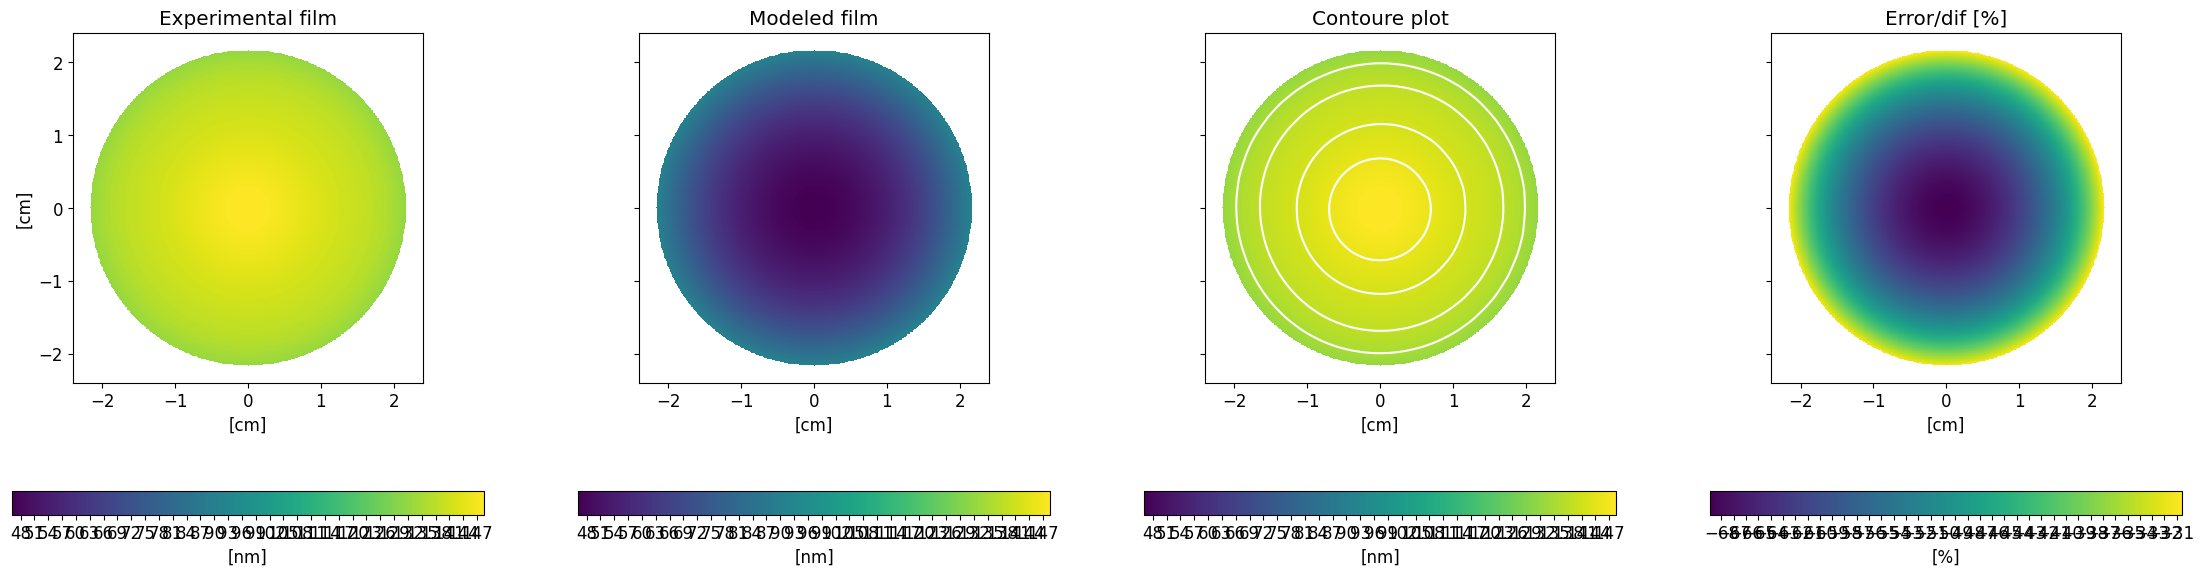

In [14]:
#Model data
model=thinfilm_4[int((res_model-res_experimental)/2):int((res_model+res_experimental)/2),int((res_model-res_experimental)/2):int((res_model+res_experimental)/2)]


pyPLD.plot_compare(Xi_5, Yi_5, Zi_5,model,res_experimental, data_lable='Experimental film', model_lable='Modeled film', error_lable='Error/dif [%]',save=False, filename='TiO2_optimized_film_3', fig_for_print=False, mask_scaling=0.9, N_contours=5, D_ticks_cbar=3, D_tick_error_cbar=1)
